# Importing Libraries

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings as w
w.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Load the dataset

In [11]:
# Load the dataset, skipping the first row
file_path = "HMEQ_Loss.xls"
df = pd.read_excel(file_path, skiprows=1)

# Show first few rows
print(df.head())
print(df.info())


   TARGET_BAD_FLAG  TARGET_LOSS_AMT  LOAN  MORTDUE     VALUE   REASON     JOB  \
0                1            641.0  1100  25860.0   39025.0  HomeImp   Other   
1                1           1109.0  1300  70053.0   68400.0  HomeImp   Other   
2                1            767.0  1500  13500.0   16700.0  HomeImp   Other   
3                1           1425.0  1500      NaN       NaN      NaN     NaN   
4                0              NaN  1700  97800.0  112000.0  HomeImp  Office   

    YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  DEBTINC  
0  10.5    0.0     0.0   94.366667   1.0   9.0      NaN  
1   7.0    0.0     2.0  121.833333   0.0  14.0      NaN  
2   4.0    0.0     0.0  149.466667   1.0  10.0      NaN  
3   NaN    NaN     NaN         NaN   NaN   NaN      NaN  
4   3.0    0.0     0.0   93.333333   0.0  14.0      NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------ 

# Handle missing values

In [12]:
# Separate numeric and categorical columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Impute numeric missing values with median
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# (Optional) For categorical: fill missing with mode
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)


# Create numeric-only dataframe (without targets)

In [13]:
# Drop target and categorical columns
numeric_df = df[num_cols].drop(columns=['TARGET_BAD_FLAG', 'TARGET_LOSS_AMT'])

print(numeric_df.head())


   LOAN  MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  \
0  1100  25860.0   39025.0  10.5    0.0     0.0   94.366667   1.0   9.0   
1  1300  70053.0   68400.0   7.0    0.0     2.0  121.833333   0.0  14.0   
2  1500  13500.0   16700.0   4.0    0.0     0.0  149.466667   1.0  10.0   
3  1500  65019.0   89235.5   7.0    0.0     0.0  173.466667   1.0  20.0   
4  1700  97800.0  112000.0   3.0    0.0     0.0   93.333333   0.0  14.0   

     DEBTINC  
0  34.818262  
1  34.818262  
2  34.818262  
3  34.818262  
4  34.818262  


# Scale the numeric data

In [14]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

scaled_df = pd.DataFrame(scaled_data, columns=numeric_df.columns)
print(scaled_df.head())


       LOAN   MORTDUE     VALUE       YOJ     DEROG    DELINQ     CLAGE  \
0 -1.562299 -1.107920 -1.099371  0.240237 -0.280976 -0.375943 -1.018026   
1 -1.544453 -0.069286 -0.582794 -0.241936 -0.280976  1.477341 -0.689350   
2 -1.526606 -1.398407 -1.491970 -0.655226 -0.280976 -0.375943 -0.358680   
3 -1.526606 -0.187596 -0.216389 -0.241936 -0.280976 -0.375943 -0.071488   
4 -1.508759  0.582831  0.183939 -0.792990 -0.280976 -0.375943 -1.030391   

       NINQ      CLNO   DEBTINC  
0 -0.102879 -1.230878  0.106963  
1 -0.707574 -0.728389  0.106963  
2 -0.102879 -1.130380  0.106963  
3 -0.102879 -0.125403  0.106963  
4 -0.707574 -0.728389  0.106963  


# Select variables for clustering

In [15]:
cluster_vars = ['LOAN', 'MORTDUE', 'VALUE']
X = scaled_df[cluster_vars]


# Determine number of clusters

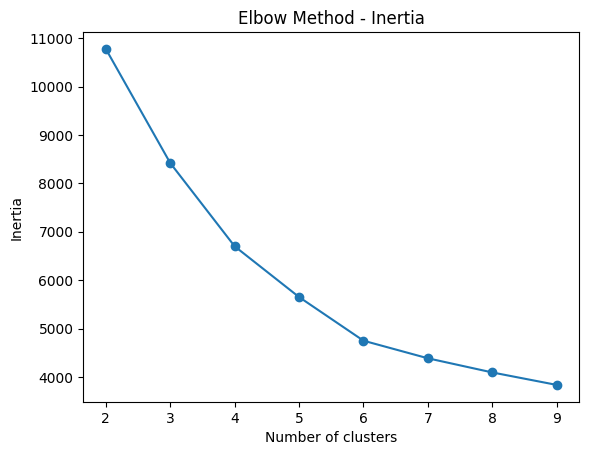

In [20]:
inertia = []
silhouette = []

for k in range(2, 10):  # trying 2 to 9 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.labels_))

# Plot inertia
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method - Inertia')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


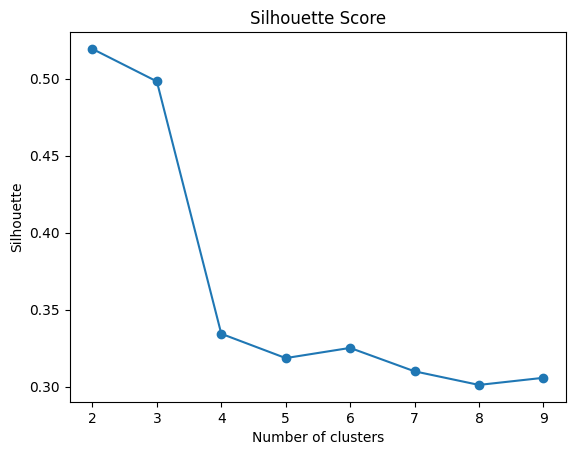

In [21]:
# Plot silhouette
plt.plot(range(2, 10), silhouette, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.show()


# Apply KMeans with chosen k

In [18]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Profile clusters
cluster_profile = df.groupby('Cluster')[cluster_vars].mean()
print(cluster_profile)


                 LOAN        MORTDUE          VALUE
Cluster                                            
0        24839.959432  144150.660913  194060.948783
1        44691.379310   47560.790640   88574.363448
2        14944.527145   59904.548279   82722.290276


# Interpret results

In [19]:
# Compare clusters with targets
cluster_risk = df.groupby('Cluster')[['TARGET_BAD_FLAG', 'TARGET_LOSS_AMT']].mean()
print(cluster_risk)



         TARGET_BAD_FLAG  TARGET_LOSS_AMT
Cluster                                  
0               0.182556     12754.724138
1               0.167488     14870.586207
2               0.205998     10908.850482
